# Project: HippoRAG Implementation

This project implements retrieval-augmented generation (RAG) using techniques described in the paper, [HippoRAG: Neurobiologically Inspired Long-Term Memory for Large Language Models](https://arxiv.org/abs/2405.14831). HippoRAG is a framework that serves as a long-term memory for LLMs and is inspired by how the human brain integrates new information into long-term memory. This approach not does require a vector database when determining the context for a RAG request. 

To provide some background, basic RAG adds new knowledge not available during LLM training by retrieving indexed passages stored in a vector database through a similarity search between RAG queries and indexed content. A recognized deficiency in this approach is the integration of a multi-hop, knowledge integration across the documents retrieved through a similarity search. Techniques such as multi-step RAG which iteratively joins disparate passages have been used to address this. 

HippoRAG leverages human brain hippocampal memory indexing theory, LLMs, and knowledge graphs to tackle knowledge integration tasks. The authors of the paper  claim this approach to RAG outperforms the state-of-the-art at a fraction of the compute time. Given a new RAG request, HippoRAG leverages the results of a Personalized PageRank (PPR) execution on a knowledge graph (KG) to determine the documents to use for the RAG context. Using the exploration of a KG's connections between nodes to determine which splits of a corpus to use in a RAG request is very different form the standard similarity search typically used for RAG.

The code below divides the implementation up into the following parts. 

- Build a schemaless KG stored in a Neo4j database. 
- Create a searchable index of entity names from the KG nodes. 
- Retrieve context relevant documents using the PPR algorithm.
- Utilize the retrieved context for RAG requests.     

The modules discussed are implemented below using LangChain, OpenAI, Neo4j, Pydantic, and yWorks.  

The source corpus used for this project is Frank Herbert's 1965 novel Dune.

Lets first import the code modules. Most of the Neo4j integration and LangChain code was placed in the utility script 'Dune_Graph_RAG_Util' to make this notebook more readable.

In [1]:
import numpy as np
import pandas as pd
import tqdm

import warnings
warnings.filterwarnings("ignore")

from langchain.text_splitter import TokenTextSplitter
import Dune_Graph_RAG_Util as util 

NUMBER_OF_SPLITS_TO_PROCESS = 5

# Building the Knowledge Graph

The steps below create a KG in a Neo4j database using entities and relationships found in the first few chapters of the Dune source corpus. For this code to work, a local instances of Neo4j desktop must be running on the default port.

### Step 1: Preprocessing Source Corpus

The code below parses the corpus file dune.txt by first getting each chapter and then splitting those chapters into chunks of approximately 500 tokens each. Each chunk is a LangChain document instance.

In [2]:
dune_chapters = util.get_Dune_chapters()
print(f'# of Dune chapters {len(dune_chapters)}')
splitter = TokenTextSplitter(encoding_name='gpt2', chunk_size=500, chunk_overlap=50)
dune_splits = splitter.split_documents(dune_chapters[:5])
print(f'# of document chunks: {len(dune_splits)}')

# of Dune chapters 48
# of document chunks: 51


Lets take a look at the distribution of split word counts.

# Of Splits: 51
Max # words in a split: 485
Min # words: 60
Average # of words: 423.67
Total # of words: 21,607


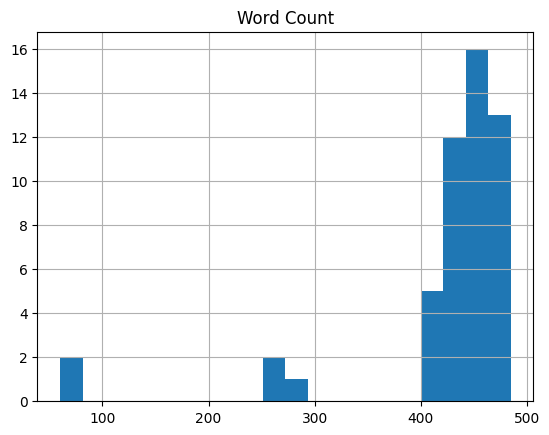

In [3]:
chpt_word_cnts = np.array([util.word_count(doc.page_content) for doc in dune_splits])
print(f'# Of Splits: {len(chpt_word_cnts)}')
print(f'Max # words in a split: {chpt_word_cnts.max():,}')
print(f'Min # words: {chpt_word_cnts.min():,}')
print(f'Average # of words: {chpt_word_cnts.mean():,.2f}')
print(f'Total # of words: {chpt_word_cnts.sum():,}')

cnt_df = pd.DataFrame(data={'Word Count': chpt_word_cnts})
hist = cnt_df.hist(bins=20)

Tbe word counts, for the most part, look correct. The smaller splits are probably due to residual splits near the end of the chapters.

### Step 2: Entity Extraction

The code below creates a list of entities by using the OpenAI Turbo 3.5 LLM to perform named entity recognition (NER) on the text splits. In addition to the entity name, the LLM is asked to describe the entity in the context of the passage it was extracted from and its type (e.g. Person, Planet, Organization, etc). The split that the entity was extracted from is also captured.

Prior to adding an entity to the list, a similarity score is calculated between the extracted entity and entities extracted in previous iterations. If the score exceeds a threshold of 0.70, the new entity is considered an alias of the existing entity. For example, two entities with the names "Duke Leto" and "Leto" are different aliases for the same entity. When an alias is found, it is not added to the main entity list but to a list in the existing entity that is used to track its aliases.

To make compute time more manageable, the code below will only process first 5 splits which will be approximately the first 2500 words of the book. 

In [4]:
entity_extractor_llm = util.get_entity_llm()

entities = []
for split, doc in enumerate(tqdm.tqdm(dune_splits[:NUMBER_OF_SPLITS_TO_PROCESS], desc ="Processing splits...")):
    new_entities = entity_extractor_llm.invoke({"context": doc}).entities
    util.initialize_entities(new_entities, split)
    entities = util.update_entity_list(new_entities, entities)

Processing splits...: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.19s/it]


Below are the name, type, and number of split references of entities extracted from the splits.

In [5]:
entities.sort(key=lambda x: x.name)
print( '\n'.join([f'{idx+1}. ' + e.name + 
                  f' ({e.type})- # of references = {len(e.entity_alias)+1}' +
                  f', Aliases = {list(set([a.name for a in e.entity_alias]))}' for idx, e in enumerate(entities)]) )

1. Arrakis (Planet)- # of references = 4, Aliases = ['Arrakis']
2. Atreides (Family House)- # of references = 4, Aliases = ['Atreides', 'Atreides family', 'House of Atreides']
3. Bene Gesserit (Organization)- # of references = 3, Aliases = ['Bene Gesserit']
4. CHOAM Company (Organization)- # of references = 1, Aliases = []
5. Caladan (Planet)- # of references = 1, Aliases = []
6. Castle Caladan (Family House)- # of references = 1, Aliases = []
7. Dr. Yueh (Person)- # of references = 1, Aliases = []
8. Duke Leto (Person)- # of references = 1, Aliases = []
9. Dune (Planet)- # of references = 1, Aliases = []
10. Fremen (Organization)- # of references = 1, Aliases = []
11. Harkonnens (Family House)- # of references = 1, Aliases = []
12. Imperial Regate (Organization)- # of references = 1, Aliases = []
13. Irulan (Person)- # of references = 1, Aliases = []
14. Jessica (Person)- # of references = 3, Aliases = ['Jessica']
15. Kwisatz Haderach (Person)- # of references = 1, Aliases = []
16. La

Reviewing the rest of the list, there are some entities that could be merged. For instance Muad'Dib is an alias for Paul. The old woman is reference to Reverend Mother Gaius. Some of issues will be addressed in subsequent curating steps. 

The code below combines an entity with the aliases found for it. The entity descriptions extracted from the splits are summarized into one description using a LLM.

In [6]:
entities = util.combine_similar_entities(entities)

Lets review the summarized entity descriptions. Listed for each entity is its name, the splits they were referenced in, and its summarized description.

In [7]:
print('\n'.join([f'{idx + 1 }. ' + e.name + f' ({",".join([str(k) for k in e.src_reference])})' 
                 + ': ' + e.description for idx, e in enumerate(entities)]))

1. Arrakis (0,1,2,3): Arrakis, also known as Dune, is the desert planet where the character Muad'Dib is located and is the main setting of the story. It is mentioned multiple times in the text.
2. Atreides (0,3): The Atreides family is a powerful and noble family that has lived in Castle Caladan for twenty-six generations. They are taking over Arrakis and are associated with a hawk crest.
3. Bene Gesserit (0,3,4): The Bene Gesserit is a knowledgeable organization that trains individuals in delicate balances and the Sight.
4. CHOAM Company (1): CHOAM Company is a powerful entity with a contract to mine the geriatric spice, melange on Arrakis.
5. Caladan (0): Caladan is the planet where Paul was born and lived his first fifteen years.
6. Castle Caladan (2): Castle Caladan is a family house mentioned in the text.
7. Dr. Yueh (2): Dr. Yueh is a character in the text.
8. Duke Leto (1): Duke Leto is the ruler of House Atreides.
9. Dune (2): Dune is a planet mentioned in the text.
10. Fremen 

This is only a partial list of entities that appear in the entire corpus as only the first 5 split where processed.

### Step 3: Create Graph Nodes

Below, the entities extracted from the corpus splits are used to create nodes in a Neo4j graph database. Nodes for entity aliases are created with a "ALSO_KNOWN_AS" relationship to the main node.  

In [8]:
%%time
util.create_nodes(entities)

CPU times: total: 0 ns
Wall time: 54.6 s


Lets visualize the current state of the KG using yWork's graphing widget. Unfortunately, the interactive widget only works when the notebook code is run. Therefore, below the code is a screenshot of the widget.

In [ ]:
util.showGraph('MATCH (n) OPTIONAL MATCH (n)-[r]->() RETURN n, r LIMIT 100')

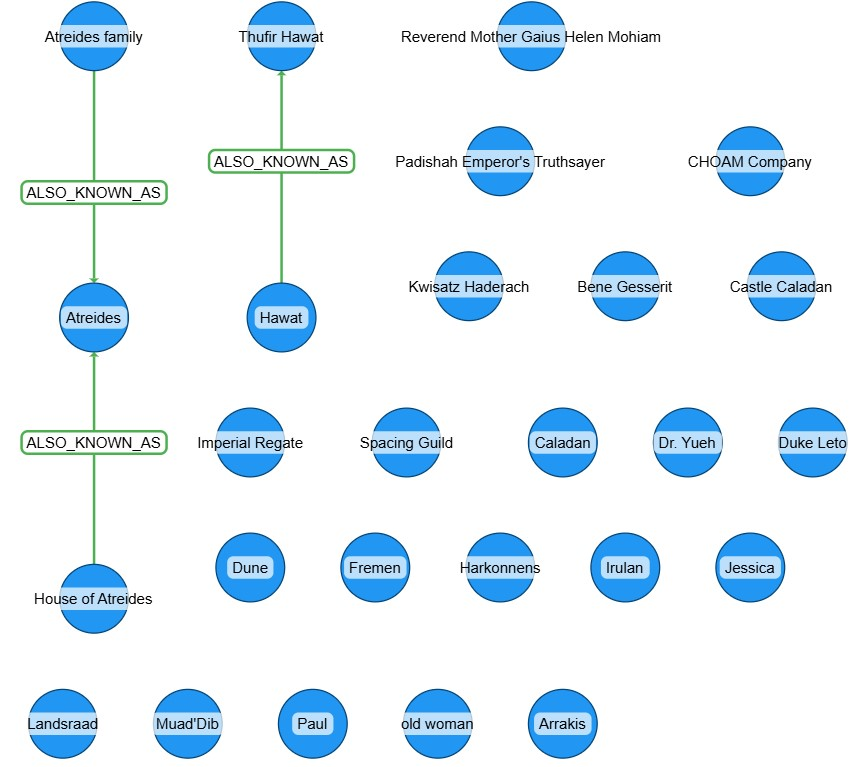

In [10]:
from IPython.display import Image
Image(filename='HR_img_1.jpg')

### Step 4: Extract Entity Relationships

Below relationships are extracted from the text splits. To curate the relationships found by the LLM, I've made the processing interactive in that users can select which relationships to ignore when adding edges to the graph database. 

In [11]:
for split, _ in enumerate(tqdm.tqdm(dune_splits[:NUMBER_OF_SPLITS_TO_PROCESS], desc ="Processing splits...")):
    split_entities, split_relationships = util.get_relationships(split, dune_splits)
    split_relationships = split_relationships.split('\n')
    print([e.name for e in split_entities])
    print( '\n'.join( [f'{split}. {r}' for split, r in enumerate(split_relationships)] ) )
    print('-----')
    idxs = input('Enter space delimited indicies of relationships to ignore:') #For example: 0 1 4 <hit enter key>
    try: exclude_idxs = list(map(int, idxs.strip().split(" ")))
    except: exclude_idxs = []
    exclude_idxs = [idx for idx in exclude_idxs if idx < len(split_relationships)]
    filtered_list = [val for idx, val in enumerate(split_relationships) if idx not in exclude_idxs]
    print(filtered_list)
    print('Adding relationships to neo4j graph...')
    util.write_relationships(filtered_list, split)
print('Done.')

Processing splits...:   0%|                                                                                | 0/5 [00:00<?, ?it/s]

['Atreides', 'House of Atreides', 'Atreides family', 'Bene Gesserit', 'Caladan', 'Irulan', 'Jessica', "Muad'Dib", 'Paul', 'Arrakis']
0. Atreides:RESIDED_ON:Caladan
1. Atreides family:RELATED_TO:Muad'Dib
2. Bene Gesserit:MENTIONED_IN:"Manual of Muad'Dib" by Irulan
3. Caladan:LOCATION_OF:Castle Caladan
4. Irulan:AUTHOR_OF:"Manual of Muad'Dib"
5. Jessica:MOTHER_OF:Paul
6. Muad'Dib:BORN_ON:Arrakis
7. Paul:RESIDED_ON:Caladan
8. Arrakis:ALSO_KNOWN_AS:Dune
-----


Enter space delimited indicies of relationships to ignore: 3


['Atreides:RESIDED_ON:Caladan', "Atreides family:RELATED_TO:Muad'Dib", 'Bene Gesserit:MENTIONED_IN:"Manual of Muad\'Dib" by Irulan', 'Irulan:AUTHOR_OF:"Manual of Muad\'Dib"', 'Jessica:MOTHER_OF:Paul', "Muad'Dib:BORN_ON:Arrakis", 'Paul:RESIDED_ON:Caladan', 'Arrakis:ALSO_KNOWN_AS:Dune']
Adding relationships to neo4j graph...


Processing splits...:  20%|██████████████▍                                                         | 1/5 [01:00<04:00, 60.12s/it]

['CHOAM Company', 'Duke Leto', 'Harkonnens', 'Jessica', 'Kwisatz Haderach', 'Landsraad', 'Paul', 'Thufir Hawat', 'Hawat', 'old woman', 'Arrakis']
0. CHOAM Company: CONTRACTED_BY: Harkonnens
1. Duke Leto: FATHER_OF: Paul
2. Harkonnens: ENEMIES_OF: House of Atreides
3. Jessica: MOTHER_OF: Paul
4. Kwisatz Haderach: IDENTITY_OF: Paul
5. Landsraad: ASSOCIATE_OF: Duke Leto
6. Paul: SON_OF: Duke Leto
7. Thufir Hawat: MASTER_OF: Assassins
8. Hawat: SERVANT_OF: Duke Leto
9. old woman: MENTOR_OF: Paul
10. Arrakis: LOCATION_OF: Dune
-----


Enter space delimited indicies of relationships to ignore: 


['CHOAM Company: CONTRACTED_BY: Harkonnens', 'Duke Leto: FATHER_OF: Paul', 'Harkonnens: ENEMIES_OF: House of Atreides', 'Jessica: MOTHER_OF: Paul', 'Kwisatz Haderach: IDENTITY_OF: Paul', 'Landsraad: ASSOCIATE_OF: Duke Leto', 'Paul: SON_OF: Duke Leto', 'Thufir Hawat: MASTER_OF: Assassins', 'Hawat: SERVANT_OF: Duke Leto', 'old woman: MENTOR_OF: Paul', 'Arrakis: LOCATION_OF: Dune']
Adding relationships to neo4j graph...


Processing splits...:  40%|████████████████████████████▊                                           | 2/5 [02:05<03:08, 63.00s/it]

['Castle Caladan', 'Dr. Yueh', 'Dune', 'Fremen', 'Imperial Regate', 'Paul', 'Arrakis']
0. Castle Caladan:LOCATED_ON:Arrakis
1. Dr. Yueh:TEACHER_OF:Paul
2. Dune:ALSO_KNOWN_AS:Arrakis
3. Fremen:INHABITANT_OF:Arrakis
4. Imperial Regate:INCLUDES:Arrakis
5. Paul:RESIDENT_OF:Castle Caladan
6. Arrakis:ALSO_KNOWN_AS:Dune
-----


Enter space delimited indicies of relationships to ignore: 0


['Dr. Yueh:TEACHER_OF:Paul', 'Dune:ALSO_KNOWN_AS:Arrakis', 'Fremen:INHABITANT_OF:Arrakis', 'Imperial Regate:INCLUDES:Arrakis', 'Paul:RESIDENT_OF:Castle Caladan', 'Arrakis:ALSO_KNOWN_AS:Dune']
Adding relationships to neo4j graph...


Processing splits...:  60%|███████████████████████████████████████████▏                            | 3/5 [03:06<02:04, 62.37s/it]

['Atreides', 'House of Atreides', 'Atreides family', 'Bene Gesserit', 'Paul', 'Reverend Mother Gaius Helen Mohiam', 'Arrakis']
0. Atreides:OWNED_BY:House of Atreides
1. Atreides family:RELATED_TO:Bene Gesserit
2. Bene Gesserit:MENTORED_BY:Reverend Mother Gaius Helen Mohiam
3. Paul:MENTORED_BY:Bene Gesserit
4. Reverend Mother Gaius Helen Mohiam:WAITING_FOR:Paul
5. Arrakis:LOCATED_ON:Arrakis
-----


Enter space delimited indicies of relationships to ignore: 0 4 5


['Atreides family:RELATED_TO:Bene Gesserit', 'Bene Gesserit:MENTORED_BY:Reverend Mother Gaius Helen Mohiam', 'Paul:MENTORED_BY:Bene Gesserit']
Adding relationships to neo4j graph...


Processing splits...:  80%|█████████████████████████████████████████████████████████▌              | 4/5 [03:55<00:57, 57.05s/it]

['Bene Gesserit', 'Jessica', "Padishah Emperor's Truthsayer", 'Paul', 'Reverend Mother Gaius Helen Mohiam', 'Spacing Guild']
0. Bene Gesserit: AFFILIATED_WITH: Reverend Mother Gaius Helen Mohiam
1. Jessica: MOTHER_OF: Paul
2. Padishah Emperor's Truthsayer: EMPLOYED_BY: Padishah Emperor
3. Paul: SON_OF: Jessica
4. Reverend Mother Gaius Helen Mohiam: SUPERIOR_OF: Jessica
5. Spacing Guild: ASSOCIATED_WITH: Reverend Mother Gaius Helen Mohiam
-----


Enter space delimited indicies of relationships to ignore: 2


['Bene Gesserit: AFFILIATED_WITH: Reverend Mother Gaius Helen Mohiam', 'Jessica: MOTHER_OF: Paul', 'Paul: SON_OF: Jessica', 'Reverend Mother Gaius Helen Mohiam: SUPERIOR_OF: Jessica', 'Spacing Guild: ASSOCIATED_WITH: Reverend Mother Gaius Helen Mohiam']
Adding relationships to neo4j graph...


Processing splits...: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [04:30<00:00, 54.16s/it]

Done.


Done.


### Step 5: Visualize Graph 

A visualization of entities and their relationships is below.

In [ ]:
util.showGraph()

Again, below is screenshot of the interactive widget.

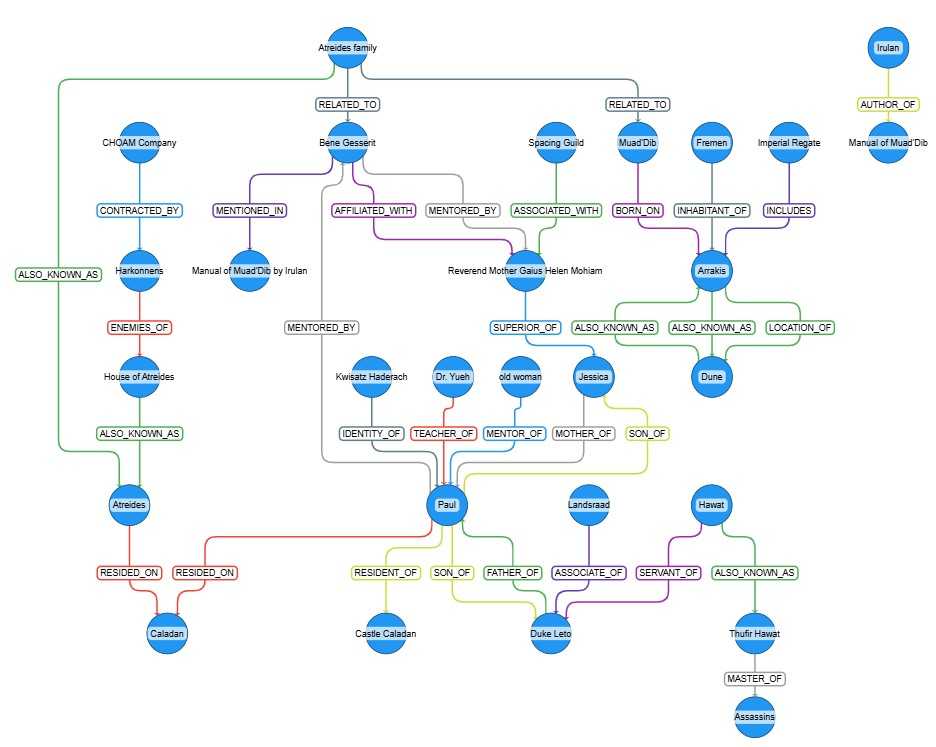

In [13]:
Image(filename='HR_img_2.jpg')

This looks pretty good but some important relationships are missing. Lets curate the graph a bit more using the graph manipulation statements below.

Below, an alias is added to Reverend Mother Gaius.

In [14]:
util.execute_write("MATCH (e1 {name: 'old woman' }) MATCH (e2 {name: 'Reverend Mother Gaius Helen Mohiam' }) MERGE (e1)-[r:ALIAS_OF]->(e2)")

Finally, Paul and Duke Leto are made members of House of Atreides.

In [16]:
util.execute_write("MATCH (e1 {name: 'Paul' }) MATCH (e2 {name: 'House of Atreides' }) MERGE (e1)-[r:MEMBER_OF]->(e2)")
util.execute_write("MATCH (e1 {name: 'Duke Leto' }) MATCH (e2 {name: 'House of Atreides' }) MERGE (e1)-[r:MEMBER_OF]->(e2)")

Now lets view the KG again.

In [ ]:
util.showGraph()

Screenshot below.

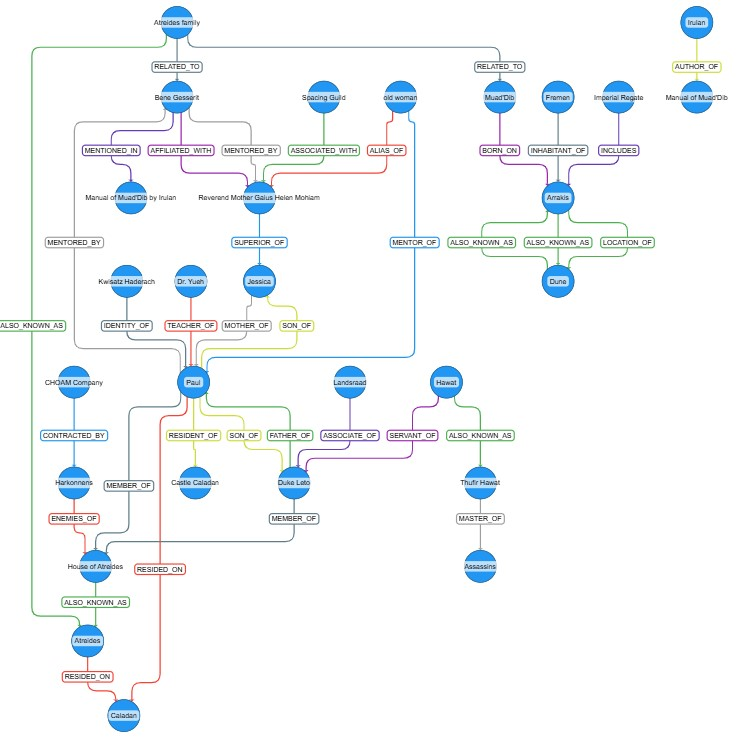

In [19]:
Image(filename='HR_img_3.jpg')

The accuracy of the graph has been enhanced by the updates.  

# Build Searchable Index For Knowledge Graph

Lets know build a search vector index inside the Neo4j KG.  




### Step 1: Retrieve all entities from KG

First, all the nodes/entities are retrieved from the KG. The data pulled from graph is mapped to instances of the custom `AnEntity` class.

In [20]:
stmt = f""" 
MATCH (n) 
RETURN ID(n) as id, n.name as name, coalesce(n.description, '') as description, coalesce(labels(n)[0],'') as type
"""
entities = [util.AnEntity(**dict(_)) for _ in util.execute_query(stmt)]
entities

[AnEntity(name='Atreides', type='', description='The Atreides family is a powerful and noble family that has lived in Castle Caladan for twenty-six generations. They are taking over Arrakis and are associated with a hawk crest.', id=0),
 AnEntity(name='House of Atreides', type='', description='', id=1),
 AnEntity(name='Atreides family', type='', description='', id=2),
 AnEntity(name='Bene Gesserit', type='', description='The Bene Gesserit is a knowledgeable organization that trains individuals in delicate balances and the Sight.', id=3),
 AnEntity(name='CHOAM Company', type='', description='CHOAM Company is a powerful entity with a contract to mine the geriatric spice, melange on Arrakis.', id=4),
 AnEntity(name='Caladan', type='', description='Caladan is the planet where Paul was born and lived his first fifteen years.', id=5),
 AnEntity(name='Castle Caladan', type='', description='Castle Caladan is a family house mentioned in the text.', id=6),
 AnEntity(name='Dr. Yueh', type='', des

### Step 2: Create And Persist Embeddings To Knowledge Graph

The code below adds vector embeddings to the entity class instances created above and persists the embeddings to the KG database. 

In [21]:
util.add_embeddings_to_nodes(entities)

### Step 3: Create vector Index

This code create the Neo4j vector index. 

The first step is to label each node in the KG with an Entity label. I do this because the Neo4j APIs used to create vector indicies require the nodes being indexed have a common label.

In [22]:
util.execute_write("MATCH (e1) SET e1:Entity")

Now lets create the vector index. The dimension of the vector embedding must be provided in the Cypher statement. 

In [23]:
len(entities[0].embedding)

384

In [24]:
util.execute_write('DROP INDEX entityIdx IF EXISTS')

stmt = """
CREATE VECTOR INDEX entityIdx
FOR (m:Entity)
ON m.embedding
OPTIONS {indexConfig: {
    `vector.dimensions`: 384,
    `vector.similarity_function`: 'cosine'
}}
"""
util.execute_write(stmt)

# Create RAG Context Using Knowledge Graph and PPR 

The code below processes a RAG request by searching the KG for entiites that have similar names to those found in the query and uses the Personalized PageRank algorithm to get a score that measures the strength of the query entites relationships to other entities in the KG. This is analogous to doing a Google search. But here, the nodes with the strongest network relationships are found instead of web links.  

### Step 1: Extract Entities from a RAG Request

Below, entities are extracted from the example request.

In [25]:
rag_query = "How is Paul related to the Bene Gesserit?"
query_entities = util.extract_entities_from_query(rag_query)
query_entities

['Paul', 'Bene Gesserit']

### Step 2: Search for entities in Neo4j Knowledge Graph

Next, using the vector index created above, a similarity search between the query entity names and the KG nodes names is performed.

In [26]:
index_entities = []
for entity in query_entities:
    similar_entities = util.do_index_similarity_search_using_index(entity)
    for se in similar_entities:
        print(se)
        print('----')
        index_entities.append(se)

name='Paul' type='' description='' score=1.0
----
name='Bene Gesserit' type='' description='' score=1.0
----


### Step 3: Calculate PPR For Entities

The code below uses Neo4j's implementaion of PPR to get scores for query entities that reflect their relationships with other import entities. What determines importance is the number of relationships any particular node has and its connection to the query entity. 

Below a Neo4j projection is created which needed before the PPR algorithm can be run.

In [27]:
stmt = "CALL gds.graph.drop('entityGraph',false)"
util.execute_write(stmt)
stmt = "CALL gds.graph.project('entityGraph','*','*')"
util.execute_write(stmt)

Now lets run the PPR algorithm. What's returned is the PPR score of the query entities (the entity names extracted from the RAG request) with all the other entities in the KG. The resul of this is a $n x N$ matrix where $n$ is the number of query entities and $N$ is the number of entity nodes in the KG.

In [28]:
entity_ppr_scores = []
for entity in index_entities:
    ppr_score = util.get_PPR_Scores(entity.name)
    print(entity.name,' PPR scores:', ppr_score)
    entity_ppr_scores.append( ppr_score)
entity_ppr_scores = np.array(entity_ppr_scores)

Paul  PPR scores: [0.03380409 0.03977057 0.         0.02790949 0.         0.05664203
 0.02790949 0.         0.02790949 0.         0.         0.
 0.         0.         0.04135205 0.         0.         0.
 0.         0.19700817 0.01581478 0.         0.         0.
 0.         0.00790739 0.         0.         0.        ]
Bene Gesserit  PPR scores: [0.01383714 0.01628052 0.         0.16142492 0.         0.0231839
 0.01142492 0.         0.01142492 0.         0.         0.
 0.         0.         0.0891762  0.         0.         0.
 0.         0.08065536 0.09147412 0.         0.         0.
 0.         0.04573706 0.         0.         0.        ]


### Step 4: Count KG Entities In Document Splits

Now lets use the query entity PPR scores to calcuate a dot product between the PPR scores and a matrix that counts the number of times each entity appears in a splits of the Dune corpus text. 

First, the entity name split occurence counts are calcualted. This result in a $N x S$ matrix where N is the number of entities in the KG and S is the total number fo splits the corpus has been divided into.

In [29]:
import sys
np.set_printoptions(threshold=sys.maxsize)

stmt = f"""
MATCH (e)
RETURN  ID(e) AS id, e.name AS name
ORDER BY ID(e)
"""
records = util.execute_query(stmt)
entity_names = [dict(d)['name'] for d in records]

entity_counts_in_splits = []
for entity in entity_names:
    split_counts = []
    for split in dune_splits:
      entityCount = split.page_content.count( entity )
      split_counts.append(entityCount)
    entity_counts_in_splits.append(split_counts)
      
entity_counts_in_splits = np.array(entity_counts_in_splits)

Let look at the entity name occurance counts across all the splits for the first entity node returned by the Cypher statement above.

In [30]:
print(f'Number of occurances of the entity "{entity_names[0]}" per corpus split:')
entity_counts_in_splits[0]

Number of occurances of the entity "Atreides" per corpus split:


array([2, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0])

### Step 5: Calculate Similarity Scores 

Before calculating the dot product, lets check the matrix dimensions.

In [31]:
print(entity_ppr_scores.shape)
print(entity_counts_in_splits.shape)

(2, 29)
(29, 51)


The 2 query entities by 29 KG nodes dimensions of the entity PPR scores looks correct. The 29 KG nodes by the 51 splits also looks correct. Let do the dot product. The resulting $n x S$ matrix captures a score which can be used to determine which splits are most relevant to the RAG request.

In [32]:
split_scores = np.dot(entity_ppr_scores, entity_counts_in_splits)
split_scores

array([[0.86908778, 1.04332991, 1.26660056, 1.21453487, 1.63174586,
        2.10388998, 0.78803269, 0.42192584, 0.39401635, 0.26626972,
        0.99479295, 0.81327608, 0.72954761, 0.        , 0.        ,
        0.06171358, 0.05664203, 0.06171358, 0.29417921, 0.        ,
        0.13528824, 0.03380409, 0.0827041 , 0.02790949, 0.03380409,
        1.12527286, 0.35117794, 0.30393129, 1.23500059, 2.01041377,
        1.09565446, 0.78434222, 0.04135205, 1.02639727, 0.4353684 ,
        0.78803269, 1.65122153, 1.18204904, 1.18204904, 1.57606539,
        1.04168289, 1.37905721, 1.57606539, 1.77307356, 1.18204904,
        0.78803269, 1.04675444, 0.98504087, 1.18204904, 1.77307356,
        0.78803269],
       [0.57803424, 0.649374  , 0.51854101, 1.09896654, 1.55325419,
        1.43930789, 0.32262146, 0.32273565, 0.16131073, 0.33125649,
        0.76850247, 1.22744312, 0.74316835, 0.        , 0.        ,
        0.02526207, 0.0231839 , 0.02526207, 0.49268141, 0.        ,
        0.05537973, 0.01383

For each query entity, lets get the index of the splits with the highest scores.

In [33]:
split_indices = np.argsort(-split_scores)
split_indices

array([[ 5, 29, 43, 49, 36,  4, 39, 42, 41,  2, 28,  3, 44, 48, 38, 37,
        25, 30, 46,  1, 40, 33, 10, 47,  0, 11, 50,  6, 35, 45, 31, 12,
        34,  7,  8, 26, 27, 18,  9, 20, 22, 17, 15, 16, 32, 24, 21, 23,
        14, 19, 13],
       [ 4,  5, 25, 11,  3, 29, 28, 26, 10, 31, 36, 12, 30, 49, 43, 27,
         1, 42, 39, 33,  0, 41,  2, 18, 48, 44, 38, 37, 46, 40, 47,  9,
         7, 35, 45,  6, 50, 34, 22,  8, 32, 20, 15, 17, 16, 24, 21, 23,
        13, 14, 19]], dtype=int64)

### Step 6: Retrieve Highest Ranked Documents For RAG Context

Using the document scores above, for each query entity, lets take the 5 highest scoring splits as long as the score is greater than zero,

In [34]:
context_splits  = set()
for sp_idx, sp in enumerate(split_indices):
    for idx in list(range(5)):
        if split_scores[sp_idx][sp[idx]] > 0:
            context_splits = context_splits.union([sp[idx]])
sorted(context_splits)

[3, 4, 5, 11, 25, 29, 36, 43, 49]

Nine split indices are identified. There 9 instead of 10 as there is some overlap between the highest scoring splits for the two query entities.

These results look correct when comparted to the intermediate results above. The splits for these indices will be used to create the RAG context.

# Make RAG Request

Using the split indicies identified above, the RAG context is created. 

In [35]:
context = '\n'.join([dune_splits[index].page_content for index in sorted(context_splits)])

Lets view a portaion of the context.

In [36]:
print(context[:200])

manent . . . strive for flow-permanence within . . . 
Over and over and over within Paul's floating awareness the lesson rolled.
When dawn touched Paul's window sill with yellow light, he sensed it th


Using the RAG request defined above that drive all the processing steps so far, lets send it and the RAG context to a RAG LLM pipeline to get the answer to the question below. 

In [37]:
print(f'RAG request: {rag_query}')
rag_chain = util.get_RAG_chain()
response = rag_chain.invoke({'question': rag_query, 'context': context })
print(f'RAG response: {response}')

RAG request: How is Paul related to the Bene Gesserit?
RAG response: Paul is related to the Bene Gesserit through his mother, Jessica, who was trained at the Bene Gesserit school.


Comparing the response to the KG visualized above, the relation described is reasonable as Paul is related to the Bene Gesserit through his mother, Jessica. This relationship probably could have been extracted from a simple RAG framework. But at the very least, the HippoRAG techniques implemented here were sufficient to create a RAG context without having to perform a similarity search across a vector database.  

# Conclusion

These results provide some evidence to confirm the results of the paper referenced in the introduction and the practicallity of using HippoRAG for incorporating new knowledge into existing LLMs.